In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import yaml
import math
from tqdm import tqdm, trange
import os

import matplotlib.pyplot as plt
import seaborn as sns   

import copy
from tqdm import tqdm

from sklearn.metrics import (
    f1_score, 
    balanced_accuracy_score, 
    confusion_matrix,
    ConfusionMatrixDisplay, 
    accuracy_score,
    classification_report
)
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

from torch.utils.tensorboard import SummaryWriter
from imblearn.over_sampling import SMOTE

import warnings
from cnn_utils import (
    PTB_Dataset,
    EarlyStopping,
    set_all_seeds,
    train_and_validate,
    test,
)

from torch import Tensor

pd.set_option('display.max_columns', None)

In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SEED = 42

TRAIN_BATCH_SIZE = 32
VAL_BATCH_SIZE = 256
TEST_BATCH_SIZE = 256

N_EPOCHS=200


In [3]:
path= r'C:\Users\pauls\Desktop\Studium\Machine Learning for Health Care\Projekt 2\project2_TS_input'
#path = "../../data"

In [4]:
# Load data
train_df = pd.read_csv(os.path.join(path, 'ptbdb_train.csv'), header=None)
test_df = pd.read_csv(os.path.join(path, 'ptbdb_test.csv'), header=None)

In [5]:
X_train_full = train_df.iloc[:, :-1].to_numpy()
y_train_full = train_df.iloc[:, -1].to_numpy()

X_test = test_df.iloc[:, :-1].to_numpy()
y_test = test_df.iloc[:, -1].to_numpy()

Split into train and validation sets:

In [6]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=SEED
)

Moreover, to deal with the large class imbalance, which we discovered in our EDA, we will use SMOTE oversampling to balance the classes in the training set and provide some data augmentation.

In [7]:
sm = SMOTE(random_state=SEED)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [9]:
train_loader = DataLoader(
        PTB_Dataset(X_train, y_train),
        batch_size=TRAIN_BATCH_SIZE,
        shuffle=True,
        pin_memory=True,
        num_workers=0,
    )
val_loader = DataLoader(
    PTB_Dataset(X_val, y_val),
    batch_size=VAL_BATCH_SIZE,
    shuffle=False,
    pin_memory=True,
    num_workers=0,
)

test_loader = DataLoader(
    PTB_Dataset(X_test, y_test),
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    pin_memory=True,
    num_workers=0,
)

## The CNN:

### CNN Class Definition: 

In [10]:
class CNN(nn.Module):
    def __init__(self, classes_num: int, in_channels: int):
        super().__init__()

        # Initial convolution layer
        # self.conv = nn.Conv1d(
        #     in_channels=in_channels, 
        #     out_channels=16, 
        #     #kernel_size=(3, 3), 
        #     kernel_size=3,
        #     padding='same', 
        #     bias=False
        # )
        # self.bn = nn.BatchNorm1d(16)
        # self.relu = nn.ReLU()
        self.conv1 = self._create_conv_block(in_channels, 32, 3, 1)
        self.conv2 = self._create_conv_block(32, 64, 3, 1)
        self.conv3 = self._create_conv_block(64, 128, 3, 1)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(output_size = 10)
        

        #Out features from the 4 blocks of residual layers: 128
        
        
        # Flattening and final linear layer
        self.flatten = nn.Flatten(1)
        #self.dropout = nn.Dropout(p=0.2)
        self.fc = nn.Sequential(
            nn.Linear(1280, 256),
            nn.Hardswish(),
            nn.Dropout(p=0.2),  
            nn.Linear(256, classes_num)
        )

    def forward(self, x: Tensor) -> Tensor:
        x = x.unsqueeze(1)    
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.adaptive_pool(x)
        
        x = self.flatten(x)
        x = self.fc(x)
        return x
    
    def _create_conv_block(self, in_channels: int, out_channels: int, kernel_size: int, stride: int):
        return nn.Sequential(
            nn.Conv1d(
                in_channels=in_channels, 
                out_channels=out_channels, 
                kernel_size=kernel_size, 
                stride=stride, 
                padding=1, 
                bias=False
            ),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )


set_all_seeds(SEED)
model=CNN(classes_num=2, in_channels=1)

### Training the CNN

In [15]:
model = model.to(DEVICE)

optimizer = optim.AdamW(model.parameters(), lr=0.005, weight_decay=0.0001)
criterion = torch.nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, "min", factor=0.5, patience=5, threshold=1e-06, verbose=1
)
early_stopping = EarlyStopping(start=20, patience=20, verbose=1, mode="max")
summary_writer = SummaryWriter(log_dir="logs/cnn")

c:\Users\pauls\miniconda3\envs\introtoml\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [ ]:
model = train_and_validate(
    model = model,
    optimizer = optimizer,
    scheduler = scheduler,
    criterion = criterion,
    train_loader = train_loader,
    val_loader = val_loader,
    best_model_path = "../weights/cnn_no_res_blocks.pth", #os.path.join(path, 'cnn_best_model.pth'),
    device = DEVICE,
    num_epochs = N_EPOCHS,
    ES = early_stopping,
    summary_writer = summary_writer
)

In [16]:
model.load_state_dict(torch.load("../weights/cnn_no_res_blocks.pth",map_location=DEVICE))
model.to(DEVICE)

CNN(
  (conv1): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (adaptive_pool): AdaptiveAvgPool1d(output_size=10)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (f

### Evaluating the CNN:

In [17]:
model_probs, y_preds, y_true, test_loss = test(
    model = model,
    criterion = criterion, 
    test_loader = test_loader, 
    device = DEVICE
)

Test loss: 0.0003, Test accuracy: 0.9942, Test balanced accuracy: 0.9918, Test F1 score: 0.9960


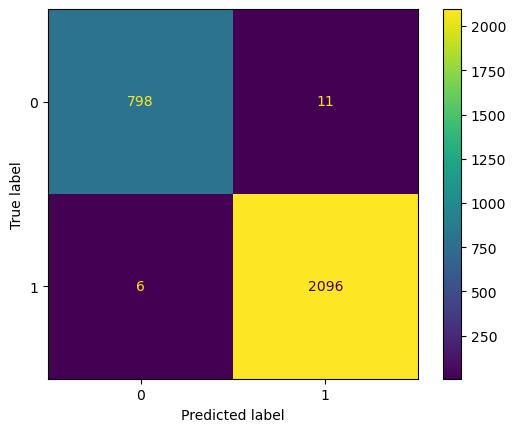

In [18]:
cm = confusion_matrix(y_true, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()

In [19]:
# calculate precision and recall:
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)

print(f"Test loss: {test_loss:.6f}")
print(f"Test accuracy: {accuracy_score(y_true, y_preds):.6f}")
print(f"Test balanced accuracy: {balanced_accuracy_score(y_true, y_preds):.6f}")
print(f"Test f1 score: {f1_score(y_true, y_preds):.6f}")
print(f"Test precision: {precision:.6f}")
print(f"Test recall: {recall:.6f}")

Test loss: 0.000314
Test accuracy: 0.994160
Test balanced accuracy: 0.991774
Test f1 score: 0.995961
Test precision: 0.994779
Test recall: 0.997146


In [20]:
print(classification_report(y_true, y_preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       809
           1       0.99      1.00      1.00      2102

    accuracy                           0.99      2911
   macro avg       0.99      0.99      0.99      2911
weighted avg       0.99      0.99      0.99      2911



## CNN with residual blocks:

In [21]:
# We based our CNN with residual blocks on this: https://medium.com/@chen-yu/building-a-customized-residual-cnn-with-pytorch-471810e894ed


class ResidualBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.conv1 = nn.Conv1d(
            in_channels=in_channels, 
            out_channels=out_channels, 
            kernel_size=3, 
            padding='same', 
            bias=False
        )
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(
            in_channels=out_channels, 
            out_channels=out_channels, 
            kernel_size=3, 
            padding='same', 
            bias=False
        )
        self.bn2 = nn.BatchNorm1d(out_channels)
        
        self.downsample = None
        if in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv1d(
                    in_channels, 
                    out_channels, 
                    kernel_size=3, 
                    padding='same', 
                    bias=False
                ),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x: Tensor) -> Tensor:
        identity = self.downsample(x) if self.downsample else x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x + identity)

        return x
    

In [22]:
class ResidualCNN(nn.Module):
    def __init__(self, classes_num: int, in_channels: int = 1, image_size: tuple = (128, 128)):
        super().__init__()

        self.conv = self._create_conv_block(in_channels=in_channels, out_channels=32, kernel_size=3, stride=1)

        # First block of residual layers and pooling
        self.layer1 = nn.Sequential(
            ResidualBlock(32, 16),
            ResidualBlock(16, 16),
            ResidualBlock(16, 16),
            nn.AvgPool1d(kernel_size=2, stride=2)
        )
        
        # Second block of residual layers and pooling
        self.layer2 = nn.Sequential(
            ResidualBlock(16, 32),
            ResidualBlock(32, 32),
            ResidualBlock(32, 32),
            nn.AvgPool1d(kernel_size=2, stride=2)
        )
        
        # Third block of residual layers and pooling
        self.layer3 = nn.Sequential(
            ResidualBlock(32, 64),
            ResidualBlock(64, 64),
            ResidualBlock(64, 64),
            nn.AvgPool1d(kernel_size=2, stride=2)
        )
        
        # Fourth block of residual layers and pooling
        self.layer4 = nn.Sequential(
            ResidualBlock(64, 128),
            ResidualBlock(128, 128),
            ResidualBlock(128, 128),
            nn.AvgPool1d(kernel_size=2, stride=2)
        )
        
        # Flattening and final linear layer
        self.flatten = nn.Flatten(1)
        self.dropout = nn.Dropout(p=0.2)
        self.linear = nn.Linear(
            in_features=int(640),
            out_features=classes_num
        )

    def forward(self, x: Tensor) -> Tensor:
        x = x.unsqueeze(1) # Add channel dimension
        x = self.conv(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.flatten(x)
        x = self.dropout(x)
        x = self.linear(x)

        return x
    
    def _create_conv_block(self, in_channels: int, out_channels: int, kernel_size: int, stride: int):
        return nn.Sequential(
            nn.Conv1d(
                in_channels=in_channels, 
                out_channels=out_channels, 
                kernel_size=kernel_size, 
                stride=stride, 
                padding=1, 
                bias=False
            ),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
    
model_res=ResidualCNN(classes_num=2, in_channels=1)


### Training the CNN with residual blocks:

In [23]:
model_res = model_res.to(DEVICE)

optimizer_res = optim.AdamW(model_res.parameters(), lr=0.005, weight_decay=0.0001)
criterion = torch.nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_res, "min", factor=0.5, patience=5, threshold=1e-06, verbose=1
)
early_stopping = EarlyStopping(start=20, patience=20, verbose=1, mode="max")
summary_writer = SummaryWriter(log_dir="logs/cnn")

c:\Users\pauls\miniconda3\envs\introtoml\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [67]:
model_res = train_and_validate(
    model = model_res,
    optimizer = optimizer_res,
    scheduler = scheduler,
    criterion = criterion,
    train_loader = train_loader,
    val_loader = val_loader,
    best_model_path = "../weights/cnn_res_blocks.pth", #os.path.join(path, 'cnn_best_model.pth'),
    device = DEVICE,
    num_epochs = N_EPOCHS,
    ES = early_stopping,
    summary_writer = summary_writer
)

c:\Users\pauls\miniconda3\envs\introtoml\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
  0%|          | 0/200 [00:00<?, ?it/s]

Training Transformer: 100%|██████████| 200/200 [3:20:39<00:00, 60.20s/it, train_balanced_acc=1, train_loss=1.18e-6, val_balanced_acc=0.997, val_loss=0.000115]    


## Evaluating the CNN with residual blocks

In [24]:
model_res.load_state_dict(torch.load("../weights/cnn_res_blocks.pth",map_location=DEVICE))
model_res.to(DEVICE)

ResidualCNN(
  (conv): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv1d(32, 16, kernel_size=(3,), stride=(1,), padding=same, bias=False)
      (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=same, bias=False)
      (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv1d(32, 16, kernel_size=(3,), stride=(1,), padding=same, bias=False)
        (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (conv1): 

In [25]:
model_probs, y_preds, y_true, test_loss = test(
    model = model_res,
    criterion = criterion, 
    test_loader = test_loader, 
    device = DEVICE
)

Test loss: 0.0003, Test accuracy: 0.9969, Test balanced accuracy: 0.9952, Test F1 score: 0.9979


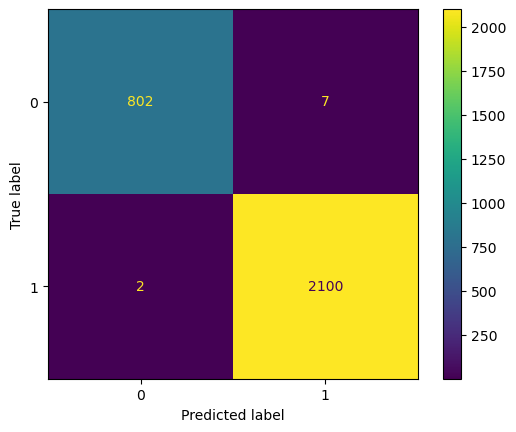

In [26]:
cm = confusion_matrix(y_true, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()

In [27]:
# calculate precision and recall:
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)

print(f"Test loss: {test_loss:.6f}")
print(f"Test accuracy: {accuracy_score(y_true, y_preds):.6f}")
print(f"Test balanced accuracy: {balanced_accuracy_score(y_true, y_preds):.6f}")
print(f"Test f1 score: {f1_score(y_true, y_preds):.6f}")
print(f"Test precision: {precision:.6f}")
print(f"Test recall: {recall:.6f}")

Test loss: 0.000262
Test accuracy: 0.996908
Test balanced accuracy: 0.995198
Test f1 score: 0.997862
Test precision: 0.996678
Test recall: 0.999049


In [28]:
print(classification_report(y_true, y_preds))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       809
           1       1.00      1.00      1.00      2102

    accuracy                           1.00      2911
   macro avg       1.00      1.00      1.00      2911
weighted avg       1.00      1.00      1.00      2911



Nice summary of the advantes of residual networks:
https://www.geeksforgeeks.org/residual-networks-resnet-deep-learning/